In [1]:
### Author: Long Nguyen

using DifferentialEquations, Flux, Zygote

# Extend Zygote to work with Neural ODE
function Zygote._zero(xs::AbstractArray{<:AbstractArray}, T=Any)
    return [Zygote._zero(x) for x in xs]
end

### ============================================================================
### Neural ODE Layer Struct and Constructor
### ============================================================================

# A Neural ODE consists of a function f(z, θ, t) that models z's derivative, and
# the parameters `θ` to be optimized, and the time span of the integral.
# Additionally, we also store the ODE solver's solution, since it is useful for
# the backward pass via the adjoint method.
struct NeuralODE{F, P, T, S}
    f::F     # derivative model
    θ::P     # vector of parameters
    tspan::T # time span [t0, t1]
    sol::S   # vector of ODE solution
end

# We store the ODE solver's solution in a vector instead of directly to make the
# `NeuralODE` struct immutable for better performace. At initialization, this is
# simply an empty vector.
function NeuralODE(f, θ, tspan)
    return NeuralODE(f, θ, tspan, DiffEqBase.AbstractODESolution[])
end

### ============================================================================
### Flux compatibility
### ============================================================================

# Using the macro `Flux.@functor` allows the machine learning library Flux to
# mix our `NeuralODE` layer in any model.
Flux.@functor NeuralODE

# We also specify the parameters `θ` to be optimized with `Flux.trainable`. We
# only update `θ` by default, but we can also optimize the time span.
Flux.trainable(node::NeuralODE) = (node.θ,)

### ============================================================================
### Forward pass
### ============================================================================

# The forward pass computes the integration with the ODE solver. The forward
# pass returns an array of the solution at each timestep.
function (node::NeuralODE)(z_t0; alg=Tsit5(), kwargs...)
    f, θ, t0, t1, sol = node.f, node.θ, node.tspan[1], node.tspan[2], node.sol
    return forward!(z_t0, θ, t0, t1; f=f, sol=sol, alg=alg, kwargs...)
end

# Integrate from `t0` to `t1` to calculate `z` at `t1`, also returns `z` at
# each timestep in a vector.
function forward!(z_t0, θ, t0, t1; f, sol, alg, kwargs...)
    # Define and solve ODE problem
    function dzdt(dz, z, θ, t)
        dz .= f(z, θ, t)
    end
    problem = ODEProblem(dzdt, z_t0, (t0, t1), θ)
    solution = solve(problem, alg; kwargs...)

    # Store the solution for the backward pass
    empty!(sol)
    push!(sol, solution)

    # Return an array of `z` evaluated at each timestep
    return solution.u
end

### ============================================================================
### Backward pass
### ============================================================================

# Since back-propagating through the ODE solver is complex, we define a custom
# backward pass for the Neural ODE via the adjoint method. Flux relies on the
# Zygote library to calculate gradients, and we can define our custom gradient
# via `Zygote.@adjoint`.
Zygote.@adjoint function forward!(z_t0, θ, t0, t1; f, sol, alg, kwargs...)
    # Forward pass
    zs = forward!(z_t0, θ, t0, t1; f=f, sol=sol, alg=alg, kwargs...)

    # Return the forward pass and how to calculate the gradients of the loss wrt
    # `z_t0` and `θ` from the gradient of the loss wrt `z` at each timestep.
    return zs, ∂L∂zs -> backward(∂L∂zs, θ; f=f, sol=sol[1], alg=alg)
end

# Compute the gradients of the loss wrt to `θ`.
function backward(∂L∂zs, θ; f, sol, alg)
    # Calculate the partial derivatives from each relevant `∂L∂z`   
    # Function to handle iszero and nothing
    function iszero_or_nothing(x)
        if x === nothing
            return true  # Treat `nothing` as zero
        else
            return iszero(x)
        end
    end
    # Ensure set_zero does not introduce Nothing values
    
    
    # Handle potential Nothing values in the iszero check
    idxs = .!(iszero_or_nothing.(∂L∂zs)) |> collect
    
    t0 = sol.t[1]
    t1s = sol.t[idxs]
    ∂s = _backward.(∂L∂zs[idxs], Ref(θ), t0, t1s; f=f, sol=sol, alg=alg)

    # Aggregate all partial derivatives
    ∂L∂t1 = ∂s[end][end]
    ∇ = map(+, [∂[1:3] for ∂ in ∂s]...)
    return (∇..., ∂L∂t1)
end

# Given the gradient of the loss wrt `z` at time `t1`, compute the partial
# derivatives wrt `z_t0` and `θ` via the adjoint method.
function _backward(∂L∂z_t1, θ, t0, t1; f, sol, alg)
    # Derivative of the loss wrt `t1`
    ∂L∂t1 = ∂L∂z_t1[:]' * f(sol[end], θ, t1)[:]

    # We define the initial augmented state, which consists of the gradients of
    # the loss wrt to `z_t1` and `θ` and `t1`. `ArrayPartition` from the
    # DifferentialEquations library allows us to combine arrays with different
    # dimensions for a single call to the ODE solver.
    s_t1 = ArrayPartition(∂L∂z_t1, zero(θ), [-∂L∂t1])

    # Define the dynamics of the augmented state
    function dsdt(ds, s, θ, t)
        # Compute the Jacobian matrices of `f` wrt `z`, `θ`, and `t`
        _, back = Zygote.pullback(f, sol(t), θ, t)

        # Adjoint dynamics
        d = back(-s.x[1])

        # Zygote returns `nothing` as a strong zero if the function is not
        # dependent on the variable, so we convert to zero for computation
        function get_derivative(Δ, x)
            if Δ == nothing
                
                return zero(x)
            else
                return Δ
            end
        end
        
        Δs = get_derivative.(d, ds.x[:])

        # Return the derivatives
        for i in 1:3
            ds.x[i] .= Δs[i]
        end
    end

    # Solve ODE backwards
    problem = ODEProblem(dsdt, s_t1, (t1, t0), θ)
    solution = solve(problem, alg)
    s_t0 = solution[end]

    # Return gradients
    return (s_t0.x[1], s_t0.x[2], -s_t0.x[3][1], ∂L∂t1)
end

_backward (generic function with 1 method)

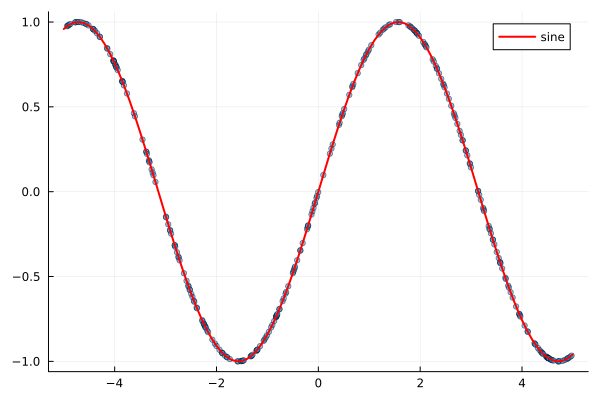

In [2]:

using Plots

### ============================================================================
### Generate Training Data
### ============================================================================

# Random input from -5 to 5
X = rand(Float32, 300) * 10 .- 5 |> sort!

# Sine function output with added noise
Y = sin.(X) .+ Float32(1e-3) * (rand(Float32, 300) .- 0.5f0)

# Visualization of sine function and training data
xgrid = -5:0.1:5
function plot_data()
	scatter(X, Y, label = :none, ms = 3, alpha = 0.5)    # training data
	plot!(xgrid, sin.(xgrid), label = "sine", lw = 2, c = :red)    # sine function
end
pl1 = plot_data()

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 8, tanh)
│   summary(x) = 1×101 adjoint(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}) with eltype Float64
└ @ Flux /Users/tianshiliu/.julia/packages/Flux/Wz6D4/src/layers/stateless.jl:60


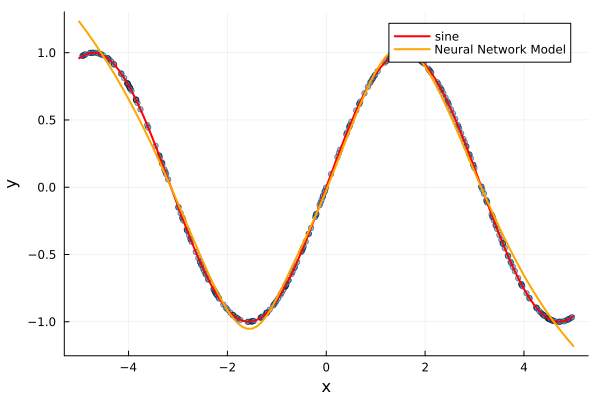

In [3]:

# Define neural network model
nn_model = Chain(Dense(1, 8, tanh), Dense(8, 1))

# Parameters to be optimized
nn_params = Flux.params(nn_model)

# Sum of squared error as loss function
nn_loss() = sum(abs2, nn_model(reshape(X, 1, :)) - Y')

# Set up to run for 100 epochs
nn_data = Iterators.repeated((), 100)

# Optimizer
nn_opt = ADAM(0.1)

# Store loss each epoch for visualization
nn_losses = Float32[]
nn_cb = () -> begin
    push!(nn_losses, nn_loss())
end

# Training loop
Flux.train!(nn_loss, nn_params, nn_data, nn_opt, cb=nn_cb)
pl2 = plot(1:100, nn_losses, label="Neural Network Model Loss", xlabel='x',ylabel='y',c=:orange)

# Network Visualization
plot!(pl1, xgrid, nn_model(xgrid')', c=:orange, lw=2, 
      xlabel="x", ylabel="y", label="Neural Network Model")

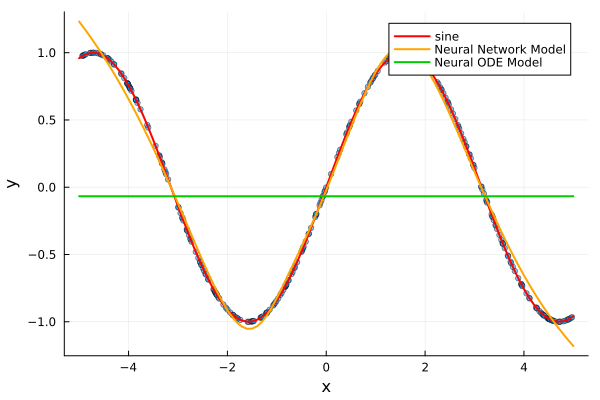

In [4]:
model = Chain(Dense(1, 8, tanh), Dense(8, 1))
θ, re = Flux.destructure(model)
dzdt(z, θ, t) = re(θ)(z)

# Define Neural ODE
node_model = NeuralODE(dzdt, θ, [0.0f0, 10.0f0])

# Parameters to be optimized, including time span
Flux.trainable(node::NeuralODE) = (node.θ, node.tspan)
node_params = Flux.params(node_model)

# Sum of squared error as loss function
node_loss() = sum(abs2, node_model(reshape(X, 1, :))[end] - Y')

# Set up to run for 100 epochs
node_data = Iterators.repeated((), 100)

# Optimizer
node_opt = ADAM(0.1)

# Store losses for visualization
node_losses = Float32[]
node_cb = () -> begin
    push!(node_losses, node_loss())
end

# Training loop
Flux.train!(node_loss, node_params, node_data, node_opt, cb=node_cb)


# Plot losses versus epochs
plot!(pl2, 1:100, node_losses, label="Neural ODE Model Loss",
      c=:green3, xlabel="Epoch", ylabel="Loss")

# Neural network visualization
plot!(pl1, xgrid, node_model(xgrid')[end]', lw=2, 
      xlabel="x", ylabel="y", label="Neural ODE Model", c=:green3)

In [5]:
# Derivative model
model = Chain(Dense(4, 8, tanh), Dense(8, 4))
θ, re = Flux.destructure(model)
dzdt(z, θ, t) = re(θ)(z)

# Define Augmented Neural ODE
anode_model = NeuralODE(dzdt, θ, [0.0f0, 10.0f0])

# Parameters to be optimized, including time span
Flux.trainable(node::NeuralODE) = (node.θ, node.tspan)
anode_params = Flux.params(anode_model)

# Input augmentation
aug_X = hcat(X, zeros(eltype(X), length(X), 3)) |> transpose

# Sum of squared error as loss function
anode_loss() = sum(abs2, anode_model(aug_X)[end][1, :] - Y)

# Set up to run for 100 epochs
anode_data = Iterators.repeated((), 100)

# Optimizer
anode_opt = ADAM(0.01)

# Store losses for visualization
anode_losses = Float32[]
anode_cb = () -> begin
    push!(anode_losses, anode_loss())
end

# Training loop
Flux.train!(anode_loss, anode_params, anode_data, anode_opt, cb=anode_cb)




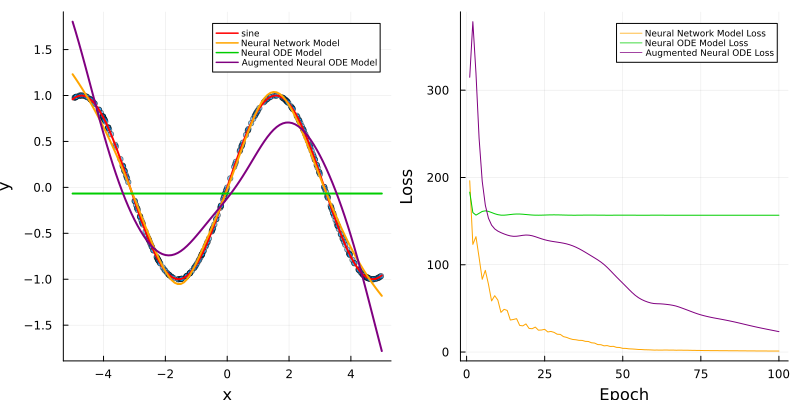

In [6]:
 # Plot losses versus epochs
plot!(pl2, 1:100, anode_losses, label="Augmented Neural ODE Loss",
xlabel="Epoch", ylabel="Loss", c=:purple)

# Augmented Neural ODE visualization
aug_xgrid = hcat(xgrid, zeros(eltype(xgrid), length(xgrid), 3)) |> transpose
plot!(pl1, xgrid, anode_model(aug_xgrid)[end][1, :], lw=2, c=:purple,
xlabel="x", ylabel="y", label="Augmented Neural ODE Model")     
# Plot all visualizations
plot(pl1, pl2, legendfontsize=6, size=(800, 400))

In [138]:

# Derivative model for [Y, dY]
θ = zeros(Float32, 2, 2)
dzdt(z, θ, t) = θ * z

# Define ODE
ode_model = NeuralODE(dzdt, θ, [X[1], X[end]])

# Parameters to be optimized
Flux.trainable(ode::NeuralODE) = (ode.θ,)
ode_params = Flux.params(ode_model)

# Set up to run for 200 loops
ode_data = Iterators.repeated((), 200)

# Approximation of first derivative from data set 
dY = [(Y[i+1] - Y[i-1])/(X[i+1] - X[i-1]) for i in 2:length(X)-1]
pushfirst!(dY, (Y[2] - Y[1])/(X[2] - X[1]))
push!(dY, (Y[end] - Y[end-1])/(X[end] - X[end-1]))

# Solve for all solutions at each time step X
predict() = ode_model([Y[1], dY[1]], saveat=X)

# Sum of squared error as loss function
ode_loss() = begin
    predicted = predict()
    sum(abs2, hcat(predicted...) - [Y'; dY'])
end

# Optimizer
ode_opt = ADAM(0.1)

# Store losses for visualization
ode_losses = Float32[]
ode_cb = () -> begin
    push!(ode_losses, ode_loss())
end

# Training loop
Flux.train!(ode_loss, ode_params, ode_data, ode_opt, cb=ode_cb)

# Plot losses versus epochs
pl3 = plot(1:200, ode_losses, label="Neural ODE Model Loss",
           c=:orange, xlabel="Epoch", ylabel="Loss")
           
# Mathematical Neural ODE visualization
pl4 = plot_data()
Ŷ = (predicted = predict(); [p[1] for p in predicted])
plot!(pl4, X, Ŷ, lw=2, c=:orange,
      xlabel="x", ylabel="y", label=" Mathematical Neural ODE Model")
      
# Show plots together
plot(pl4, pl3, size=(800, 400))

ErrorException: Something went wrong. Integrator stepped past tstops but the algorithm was dtchangeable. Please report this error.

In [85]:
# read the data
using DataFrames, CSV, Plots
amzn = CSV.read("/Users/tianshiliu/Desktop/financial time series folder/data/AMZN.csv",DataFrame)

Row,Date,Adj Close
,String15,Float64
1,5/15/1997,1.95833
2,5/16/1997,1.72917
3,5/19/1997,1.70833
4,5/20/1997,1.63542
5,5/21/1997,1.42708
6,5/22/1997,1.39583
7,5/23/1997,1.5
8,5/27/1997,1.58333
9,5/28/1997,1.53125


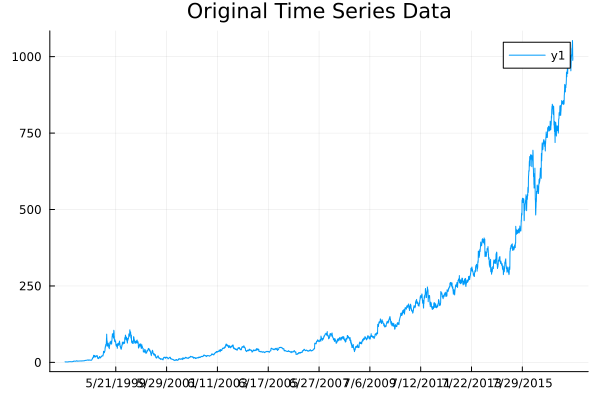

In [86]:
# Plot the original data
p1 = plot(amzn."Date", amzn."Adj Close", title="Original Time Series Data", legend=:topright)

In [87]:
# Display the structure of the data
describe(amzn)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Date,,1/10/2000,,9/9/2016,0,String15
2,Adj Close,170.242,1.39583,69.4437,1052.8,0,Float64


In [88]:
# Normalising the data
using Statistics

# Function to perform Min-Max normalisation
function min_max_scaling(column)
    min_val = minimum(column)
    max_val = maximum(column)
    return (column .- min_val) ./ (max_val .- min_val)
end

# Apply Min-Max normalisation to normalise data
amzn_norm = copy(amzn)
for col in names(amzn_norm)
    if eltype(amzn_norm[!, col]) <: Number
        amzn_norm[!, col] = min_max_scaling(amzn_norm[!, col])
    end
end

# Display the normalised data
first(amzn_norm, 5)


Row,Date,Adj Close
,String15,Float64
1,5/15/1997,0.000534999
2,5/16/1997,0.000317037
3,5/19/1997,0.000297222
4,5/20/1997,0.00022787
5,5/21/1997,2.97222e-5


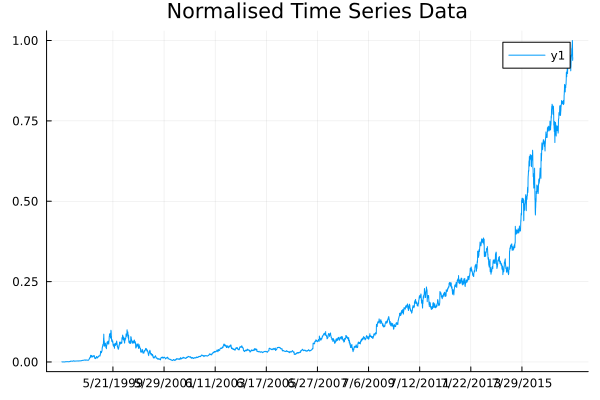

In [89]:
# Plot the Min-Max normalised data
p2 = plot(amzn_norm."Date", amzn_norm."Adj Close", title="Normalised Time Series Data", legend=:topright)

In [115]:
using DataFrames
using Plots
using DataInterpolations
using Dates

# Extract sorted dates and adjusted close values
dates = amzn_norm."Date"
print(dates)
adj_close = amzn_norm."Adj Close"

# Ensure that the "Adj Close" column is of type Float64
adj_close = Float64.(adj_close)





String15["5/15/1997", "5/16/1997", "5/19/1997", "5/20/1997", "5/21/1997", "5/22/1997", "5/23/1997", "5/27/1997", "5/28/1997", "5/29/1997", "5/30/1997", "6/2/1997", "6/3/1997", "6/4/1997", "6/5/1997", "6/6/1997", "6/9/1997", "6/10/1997", "6/11/1997", "6/12/1997", "6/13/1997", "6/16/1997", "6/17/1997", "6/18/1997", "6/19/1997", "6/20/1997", "6/23/1997", "6/24/1997", "6/25/1997", "6/26/1997", "6/27/1997", "6/30/1997", "7/1/1997", "7/2/1997", "7/3/1997", "7/7/1997", "7/8/1997", "7/9/1997", "7/10/1997", "7/11/1997", "7/14/1997", "7/15/1997", "7/16/1997", "7/17/1997", "7/18/1997", "7/21/1997", "7/22/1997", "7/23/1997", "7/24/1997", "7/25/1997", "7/28/1997", "7/29/1997", "7/30/1997", "7/31/1997", "8/1/1997", "8/4/1997", "8/5/1997", "8/6/1997", "8/7/1997", "8/8/1997", "8/11/1997", "8/12/1997", "8/13/1997", "8/14/1997", "8/15/1997", "8/18/1997", "8/19/1997", "8/20/1997", "8/21/1997", "8/22/1997", "8/25/1997", "8/26/1997", "8/27/1997", "8/28/1997", "8/29/1997", "9/2/1997", "9/3/1997", "9/4/1997"

"3/16/1999", "3/17/1999", "3/18/1999", "3/19/1999", "3/22/1999", "3/23/1999", "3/24/1999", "3/25/1999", "3/26/1999", "3/29/1999", "3/30/1999", "3/31/1999", "4/1/1999", "4/5/1999", "4/6/1999", "4/7/1999", "4/8/1999", "4/9/1999", "4/12/1999", "4/13/1999", "4/14/1999", "4/15/1999", "4/16/1999", "4/19/1999", "4/20/1999", "4/21/1999", "4/22/1999", "4/23/1999", "4/26/1999", "4/27/1999", "4/28/1999", "4/29/1999", "4/30/1999", "5/3/1999", "5/4/1999", "5/5/1999", "5/6/1999", "5/7/1999", "5/10/1999", "5/11/1999", "5/12/1999", "5/13/1999", "5/14/1999", "5/17/1999", "5/18/1999", "5/19/1999", "5/20/1999", "5/21/1999", "5/24/1999", "5/25/1999", "5/26/1999", "5/27/1999", "5/28/1999", "6/1/1999", "6/2/1999", "6/3/1999", "6/4/1999", "6/7/1999", "6/8/1999", "6/9/1999", "6/10/1999", "6/11/1999", "6/14/1999", "6/15/1999", "6/16/1999", "6/17/1999", "6/18/1999", "6/21/1999", "6/22/1999", "6/23/1999", "6/24/1999", "6/25/1999", "6/28/1999", "6/29/1999", "6/30/1999", "7/1/1999", "7/2/1999", "7/6/1999", "7/7/19

5088-element Vector{Float64}:
 0.0005349988058255989
 0.00031703696345079124
 0.0002972215587919994
 0.00022787049581319142
 2.972215587919994e-5
 0.0
 9.907416996699574e-5
 0.00017833293527519964
 0.00012879632584619568
 0.00010402754557719979
 ⋮
 0.9741964083963689
 0.9868270473056578
 0.987702109423537
 1.0
 0.9935324122763457
 0.968841602019979
 0.9381588745693218
 0.9461576754795894
 0.9458723551475658

In [116]:
# Define the output date format
output_date_format = DateFormat("yyyy/mm/dd")

# Function to parse date strings with mixed formats
function parse_mixed_date(date_str)
    # Attempt to parse with "m/d/yyyy" format
    date_parsed = nothing
    try
        date_parsed = Date(date_str, DateFormat("m/d/yyyy"))
    catch
    end
    
    # Attempt to parse with "m/dd/yyyy" format if not already parsed
    if isnothing(date_parsed)
        try
            date_parsed = Date(date_str, DateFormat("m/dd/yyyy"))
        catch
        end
    end
    
    return date_parsed
end

# Transform each date string into the desired format
formatted_dates = [Dates.format(parse_mixed_date(date), output_date_format) for date in dates]


5088-element Vector{String}:
 "1997/05/15"
 "1997/05/16"
 "1997/05/19"
 "1997/05/20"
 "1997/05/21"
 "1997/05/22"
 "1997/05/23"
 "1997/05/27"
 "1997/05/28"
 "1997/05/29"
 ⋮
 "2017/07/21"
 "2017/07/24"
 "2017/07/25"
 "2017/07/26"
 "2017/07/27"
 "2017/07/28"
 "2017/07/31"
 "2017/08/01"
 "2017/08/02"

In [127]:
# Convert formatted dates to Date objects
Formatted_dates = Date.(formatted_dates, output_date_format)

# Transform each date into the relative date with respect to the initial date.
init_date = Formatted_dates[1]
rel_dates = []
for x in Formatted_dates
    x = x - init_date
    push!(rel_dates,Dates.value(x))
end
# Ensure that rel_dates are sorted
sort!(rel_dates)

# Convert rel_dates into Float64
rel_dates = Float64.(rel_dates)

5088-element Vector{Float64}:
    0.0
    1.0
    4.0
    5.0
    6.0
    7.0
    8.0
   12.0
   13.0
   14.0
    ⋮
 7372.0
 7375.0
 7376.0
 7377.0
 7378.0
 7379.0
 7382.0
 7383.0
 7384.0

In [128]:
typeof(rel_dates)

Vector{Float64} (alias for Array{Float64, 1})

In [149]:
cubic_spline = undef

UndefInitializer(): array initializer with undefined values

In [152]:
# Create a zipped vector of rel_dates and adj_close
time_series = collect(zip(rel_dates, adj_close))

# Create a cubic spline interpolation of the normalized time series data
cubic_spline_t = DataInterpolations.CubicSpline(rel_dates, rel_dates)
cubic_spline_p = DataInterpolations.CubicSpline(adj_close, rel_dates)

function cubic_spline_2d(t)
    return (cubic_spline_t(t), cubic_spline_p(t))
end

cubic_spline_2d(rel_dates)

(Any[0.0, 1.0, 4.0, 5.0, 6.0, 7.0, 8.0, 12.0, 13.0, 14.0  …  7371.0, 7372.0, 7375.0, 7376.0, 7377.0, 7378.0, 7379.0, 7382.0, 7383.0, 7384.0], Any[0.0005349988058255989, 0.00031703696345079124, 0.0002972215587919994, 0.00022787049581319142, 2.972215587919994e-5, 0.0, 9.907416996699574e-5, 0.00017833293527519964, 0.00012879632584619568, 0.00010402754557719979  …  0.9770781801772803, 0.974196408396369, 0.9868270473056578, 0.987702109423537, 1.0, 0.9935324122763457, 0.9688416020199789, 0.9381588745693218, 0.9461576754795894, 0.9458723551475658])

In [ ]:

# Define neural network model
nn_model = Chain(Dense(2, 16, relu))

# Parameters to be optimized
nn_params = Flux.params(nn_model)

# Sum of squared error as loss function
nn_loss() = sum(abs2, nn_model(reshape(X, 1, :)) - Y')

# Set up to run for 100 epochs
nn_data = Iterators.repeated((), 100)

# Optimizer
nn_opt = ADAM(0.1)

# Store loss each epoch for visualization
nn_losses = Float32[]
nn_cb = () -> begin
    push!(nn_losses, nn_loss())
end

# Training loop
Flux.train!(nn_loss, nn_params, nn_data, nn_opt, cb=nn_cb)
pl2 = plot(1:100, nn_losses, label="Neural Network Model Loss", xlabel='x',ylabel='y',c=:orange)

# Network Visualization
plot(pl1, xgrid, nn_model(xgrid')', c=:orange, lw=2, 
      xlabel="x", ylabel="y", label="Neural Network Model")

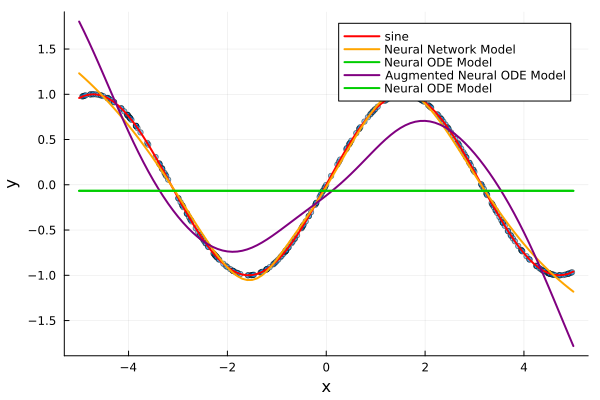

In [140]:
model = Chain(Dense(1, 8, relu), Dense(8, 1))
θ, re = Flux.destructure(model)
f(z, θ, t) = re(θ)(z)

# Define Neural ODE
node_model = NeuralODE(f, θ, [0.0f0, 10.0f0])

# Parameters to be optimized, including time span
Flux.trainable(node::NeuralODE) = (node.θ, node.tspan)
node_params = Flux.params(node_model)

# Sum of squared error as loss function
node_loss() = sum(abs2, node_model(reshape(X, 1, :))[end] - Y')

# Set up to run for 100 epochs
node_data = Iterators.repeated((), 100)

# Optimizer
node_opt = ADAM(0.1)

# Store losses for visualization
node_losses = Float32[]
node_cb = () -> begin
    push!(node_losses, node_loss())
end

# Training loop
Flux.train!(node_loss, node_params, node_data, node_opt, cb=node_cb)


# Plot losses versus epochs
plot!(pl2, 1:100, node_losses, label="Neural ODE Model Loss",
      c=:green3, xlabel="Epoch", ylabel="Loss")

# Neural network visualization
plot!(pl1, xgrid, node_model(xgrid')[end]', lw=2, 
      xlabel="x", ylabel="y", label="Neural ODE Model", c=:green3)